In [1]:
# 1. Download Dataset (Colab)
import kagglehub, os

dataset_path = kagglehub.dataset_download("ashenafifasilkebede/dataset")
print("Dataset path:", dataset_path)
print(os.listdir(dataset_path))


Using Colab cache for faster access to the 'dataset' dataset.
Dataset path: /kaggle/input/dataset
['val', 'test', 'train']


In [2]:
# 2. Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


In [3]:
# 3. Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 30

DATA_PATH = {
    "train": os.path.join(dataset_path, "train"),
    "val": os.path.join(dataset_path, "val"),
    "test": os.path.join(dataset_path, "test")
}


In [4]:
# 4. Data Generators
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.4,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
).flow_from_directory(
    DATA_PATH["train"],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    DATA_PATH["val"],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    DATA_PATH["test"],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [5]:
# 5. Class Weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.015605749486653), 1: np.float64(0.9848665870171247)}


In [6]:
# 6. Build & Fine-Tune VGG16
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,905 (57.14 MB)

 Trainable params: 7,343,617 (28.01 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [7]:
# 7. Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", "Precision", "Recall", "AUC"]
)


In [8]:
# 8. Train
cb = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_model_high_accuracy.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=cb
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - AUC: 0.5770 - Precision: 0.5598 - Recall: 0.5780 - accuracy: 0.5618 - loss: 0.8612

619/619 ━━━━━━━━━━━━━━━━━━━━ 196s 300ms/step - AUC: 0.5771 - Precision: 0.5599 - Recall: 0.5780 - accuracy: 0.5619 - loss: 0.8610 - val_AUC: 0.7063 - val_Precision: 0.8772 - val_Recall: 0.5435 - val_accuracy: 0.5917 - val_loss: 0.9334
Epoch 2/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - AUC: 0.7457 - Precision: 0.6906 - Recall: 0.6999 - accuracy: 0.6874 - loss: 0.6450

619/619 ━━━━━━━━━━━━━━━━━━━━ 141s 227ms/step - AUC: 0.7458 - Precision: 0.6907 - Recall: 0.6999 - accuracy: 0.6875 - loss: 0.6449 - val_AUC: 0.7803 - val_Precision: 0.9014 - val_Recall: 0.6957 - val_accuracy: 0.7083 - val_loss: 0.7253
Epoch 3/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - AUC: 0.7988 - Precision: 0.7349 - Recall: 0.7058 - accuracy: 0.7205 - loss: 0.5728

619/619 ━━━━━━━━━━━━━━━━━━━━ 138s 223ms/step - AUC: 0.7989 - Precision: 0.7349 - Recall: 0.7058 - accuracy: 0.7205 - loss: 0.5728 - val_AUC: 0.8358 - val_Precision: 0.8416 - val_Recall: 0.9239 - val_accuracy: 0.8083 - val_loss: 0.4385
Epoch 4/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 137s 222ms/step - AUC: 0.8385 - Precision: 0.7765 - Recall: 0.7539 - accuracy: 0.7609 - loss: 0.5118 - val_AUC: 0.8282 - val_Precision: 0.8713 - val_Recall: 0.9565 - val_accuracy: 0.8583 - val_loss: 0.4660
Epoch 5/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 138s 223ms/step - AUC: 0.8690 - Precision: 0.8010 - Recall: 0.7809 - accuracy: 0.7915 - loss: 0.4655 - val_AUC: 0.8822 - val_Precision: 0.9383 - val_Recall: 0.8261 - val_accuracy: 0.8250 - val_loss: 0.5633
Epoch 6/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 139s 224ms/step - AUC: 0.8922 - Precision: 0.8031 - Recall: 0.8087 - accuracy: 0.8064 - loss: 0.4224 - val_AUC: 0.8624 - val_Precision: 0.8641 - val_Recall: 0.9674 - val_accuracy: 0.8583 - val_loss: 0.4837
Epoch 7/30
619/619 ━━━━━━━━

619/619 ━━━━━━━━━━━━━━━━━━━━ 139s 224ms/step - AUC: 0.8960 - Precision: 0.8211 - Recall: 0.8008 - accuracy: 0.8122 - loss: 0.4162 - val_AUC: 0.9123 - val_Precision: 0.8738 - val_Recall: 0.9783 - val_accuracy: 0.8750 - val_loss: 0.3255
Epoch 8/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - AUC: 0.8984 - Precision: 0.8239 - Recall: 0.8124 - accuracy: 0.8162 - loss: 0.4172

619/619 ━━━━━━━━━━━━━━━━━━━━ 138s 223ms/step - AUC: 0.8984 - Precision: 0.8239 - Recall: 0.8124 - accuracy: 0.8163 - loss: 0.4172 - val_AUC: 0.9332 - val_Precision: 0.9053 - val_Recall: 0.9348 - val_accuracy: 0.8750 - val_loss: 0.3088
Epoch 9/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 137s 221ms/step - AUC: 0.9193 - Precision: 0.8544 - Recall: 0.8284 - accuracy: 0.8381 - loss: 0.3763 - val_AUC: 0.9127 - val_Precision: 0.8725 - val_Recall: 0.9674 - val_accuracy: 0.8667 - val_loss: 0.3976
Epoch 10/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 137s 221ms/step - AUC: 0.9095 - Precision: 0.8316 - Recall: 0.8226 - accuracy: 0.8249 - loss: 0.3957 - val_AUC: 0.9189 - val_Precision: 0.8878 - val_Recall: 0.9457 - val_accuracy: 0.8667 - val_loss: 0.3201
Epoch 11/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 137s 222ms/step - AUC: 0.9372 - Precision: 0.8751 - Recall: 0.8586 - accuracy: 0.8660 - loss: 0.3217 - val_AUC: 0.9241 - val_Precision: 0.9101 - val_Recall: 0.8804 - val_accuracy: 0.8417 - val_loss: 0.3640
Epoch 12/30
619/619 ━━━━━

619/619 ━━━━━━━━━━━━━━━━━━━━ 137s 221ms/step - AUC: 0.9469 - Precision: 0.8837 - Recall: 0.8848 - accuracy: 0.8815 - loss: 0.2989 - val_AUC: 0.9460 - val_Precision: 0.9432 - val_Recall: 0.9022 - val_accuracy: 0.8833 - val_loss: 0.2969
Epoch 14/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - AUC: 0.9477 - Precision: 0.8961 - Recall: 0.8734 - accuracy: 0.8845 - loss: 0.2960

619/619 ━━━━━━━━━━━━━━━━━━━━ 135s 218ms/step - AUC: 0.9477 - Precision: 0.8961 - Recall: 0.8734 - accuracy: 0.8845 - loss: 0.2960 - val_AUC: 0.9610 - val_Precision: 0.9255 - val_Recall: 0.9457 - val_accuracy: 0.9000 - val_loss: 0.2084
Epoch 15/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 135s 218ms/step - AUC: 0.9436 - Precision: 0.8785 - Recall: 0.8690 - accuracy: 0.8735 - loss: 0.3115 - val_AUC: 0.9113 - val_Precision: 0.9158 - val_Recall: 0.9457 - val_accuracy: 0.8917 - val_loss: 0.2791
Epoch 16/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - AUC: 0.9545 - Precision: 0.8919 - Recall: 0.8874 - accuracy: 0.8874 - loss: 0.2751

619/619 ━━━━━━━━━━━━━━━━━━━━ 133s 215ms/step - AUC: 0.9545 - Precision: 0.8919 - Recall: 0.8874 - accuracy: 0.8873 - loss: 0.2751 - val_AUC: 0.9653 - val_Precision: 0.9255 - val_Recall: 0.9457 - val_accuracy: 0.9000 - val_loss: 0.2067
Epoch 17/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 133s 215ms/step - AUC: 0.9552 - Precision: 0.8894 - Recall: 0.8928 - accuracy: 0.8922 - loss: 0.2744 - val_AUC: 0.9542 - val_Precision: 0.9263 - val_Recall: 0.9565 - val_accuracy: 0.9083 - val_loss: 0.2272
Epoch 18/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 133s 214ms/step - AUC: 0.9636 - Precision: 0.8998 - Recall: 0.8975 - accuracy: 0.8992 - loss: 0.2463 - val_AUC: 0.9350 - val_Precision: 0.9072 - val_Recall: 0.9565 - val_accuracy: 0.8917 - val_loss: 0.2861
Epoch 19/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 133s 215ms/step - AUC: 0.9647 - Precision: 0.9037 - Recall: 0.8983 - accuracy: 0.9006 - loss: 0.2443 - val_AUC: 0.9028 - val_Precision: 0.8990 - val_Recall: 0.9674 - val_accuracy: 0.8917 - val_loss: 0.3794
Epoch 20/30
619/619 ━━━━

In [27]:
history.history.keys()

dict_keys(['AUC', 'Precision', 'Recall', 'accuracy', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss'])

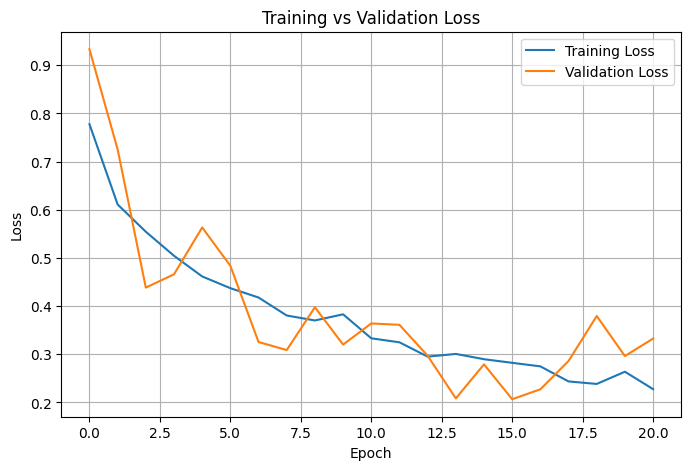

In [20]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

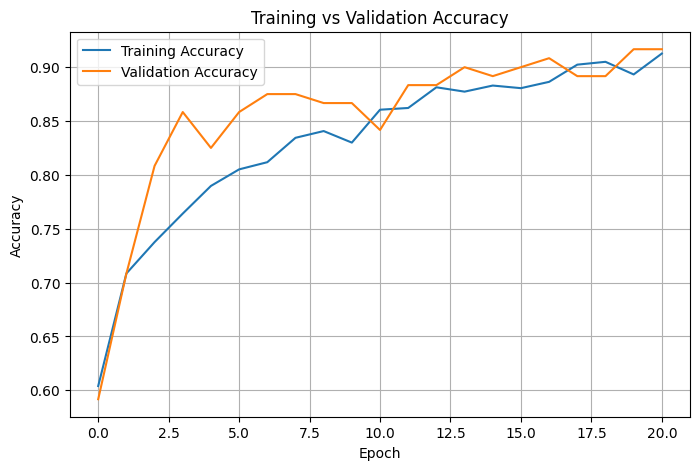

In [21]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

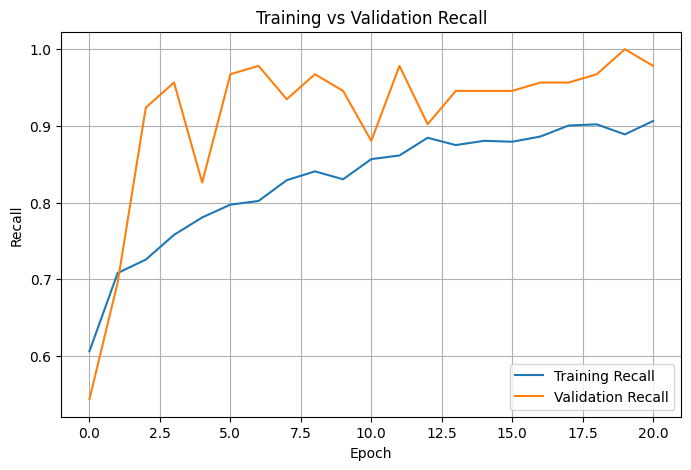

In [29]:
plt.figure(figsize=(8,5))
plt.plot(history.history['Recall'], label='Training Recall')
plt.plot(history.history['val_Recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend()
plt.grid(True)
plt.show()


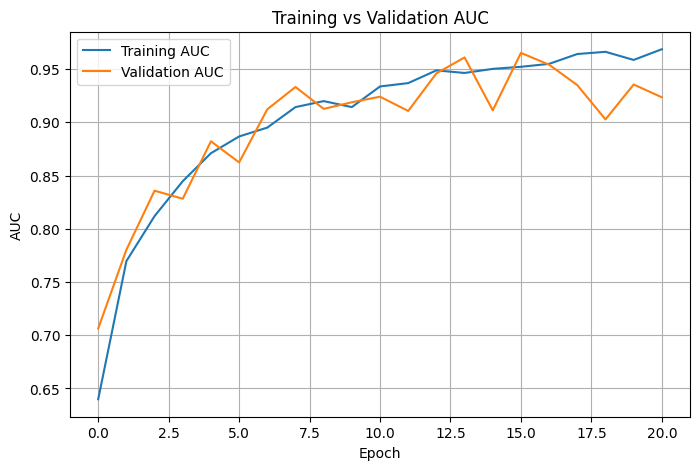

In [30]:
plt.figure(figsize=(8,5))
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 9. Evaluation
from sklearn.metrics import classification_report

pred = model.predict(test_gen)
pred_labels = (pred > 0.7).astype(int)

print(classification_report(test_gen.classes, pred_labels))


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 778ms/step
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        31
           1       0.96      0.85      0.91        95

    accuracy                           0.87       126
   macro avg       0.82      0.88      0.84       126
weighted avg       0.89      0.87      0.87       126



In [19]:
# 10. Single Image Prediction
from tensorflow.keras.preprocessing import image
import random

normal_dir = os.path.join(DATA_PATH["val"], "Normal")
img_name = random.choice(os.listdir(normal_dir))
img_path = os.path.join(normal_dir, img_name)

img = image.load_img(img_path, target_size=IMG_SIZE)
img_arr = image.img_to_array(img)
img_arr = preprocess_input(img_arr)
img_arr = np.expand_dims(img_arr, axis=0)

prediction = model.predict(img_arr)[0][0]
print("Raw prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Raw prediction: 0.0041037644
